In [46]:
from ff_energy.ffe.slurm import SlurmJobHandler
from pathlib import Path
import pandas as pd
import jax.numpy as jnp
import itertools as it
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



from ff_energy.ffe.potential import (
    LJ,
    DE,
)

from ff_energy.ffe.ff import FF

from ff_energy.plotting.ffe_plots import plot_energy_MSE, plot_ff_fit
from ff_energy.plotting.plotting import set_style
from ff_energy.plotting.fit_results import residuals_plot
from ff_energy.logs.logging import hide_logs

hide_logs()


import scienceplots
set_style(no_latex=True)

# sns.set_style()
# plt.style.use(["science", "no-latex"])


from ff_energy.ffe.ff_fit import (
    load_ff,
    fit_func,
    fit_repeat,
)

from ff_energy.utils.ffe_utils import pickle_output, read_from_pickle, str2int, PKL_PATH
from ff_energy.utils.json_utils import load_json

structure_data = {
    "dcm": "",
    "water_cluster": PKL_PATH / "20230823_water_clusters.pkl.pkl",
}

"""
Variables
"""
sig_bound = (0.001, 2.5)
ep_bound = (0.001, 2.5)
chg_bound = (100, 2000)
CHGPEN_bound = [(chg_bound), (chg_bound), (chg_bound), (chg_bound), (0, 2000)]
LJ_bound = ((sig_bound), (sig_bound), (ep_bound), (ep_bound))
DE_bound = ((sig_bound), (sig_bound), (ep_bound), (ep_bound), (1, 8), (6, 20))

NFIT_COUL = 1
NFIT_LJ = 4
NFIT_DE = 6

pkl_files = []
json_object = load_json("exp1.json")
#  make a product of all the values in the json object
experiments = list(it.product(*json_object.values()))
print(f"N experiments: {len(experiments)}")

N experiments: 10


In [2]:
# ts = np.array(list(zip(df_test["target"], [0]*len(df_test), df_test["target"]*1, [1]*len(df_test))))
# ts.T.shape
# vs = np.array(list(zip(df_test["target"]*1, [1]*len(df_test))))
# vs.T.shape

In [3]:
# x_vals = np.zeros(len(df_test)*2)
# y_vals = np.zeros(len(df_test)*2)

# x_vals[0::2] = df_test["target"]*1.1
# x_vals[1::2] = df_test["target"]
# print(y_vals.shape)
# y_vals[1::2] = [1]*len(df_test)
# plt.clf()
# for i in range(len(df_test)):
#     print(i)
#     plt.plot(x_vals[i*2:i*2+2], y_vals[i*2:i*2+2], alpha=1)

In [4]:
# debug.data

In [ ]:
fitted_ = {_.stem: pd.read_pickle(_) for _ in list(PKL_PATH.glob("*fitted*"))}
fitted_.keys()

In [6]:
fitkeys = list(fitted_.keys())
fitkeys = [
  #   'ELECnull_water_cluster_lj_fitted',
  # 'ELECci_water_cluster_lj_fitted',
  'ELECpol_water_cluster_lj_fitted',
  # 'ELECk_water_cluster_lj_fitted',
  # 'ELECm_water_cluster_lj_fitted',
  # 'ELECp_water_cluster_lj_fitted',
  # 'ELECnull_dcm_lj_fitted',
  # 'ELECci_dcm_lj_fitted',
  # 'ELECpol_dcm_lj_fitted',
  # 'ELECm_dcm_lj_fitted',
  # 'ELECp_dcm_lj_fitted'
]

#  DEBUGGING


In [30]:
debug = fitted_["ELECm_water_cluster_lj_fitted"]
debug

FF: LJ water_cluster ELECm Exact intE (jax_coloumb: False)

In [26]:
print("len dists:", len(debug.out_dists))
print("atom type pairs:", (debug.atom_types))
print("atom types:", (debug.atom_type_pairs))
print("atom types:", (debug.atom_type_pairs))

len dists: 855000
atom type pairs: ['OT', 'HT']
atom types: [('HT', 'HT'), ('HT', 'OT'), ('OT', 'OT')]
atom types: [('HT', 'HT'), ('HT', 'OT'), ('OT', 'OT')]


In [29]:
debug.dists.keys()

dict_keys(['test306', 'test324', 'test18', 'test105', 'test112', 'test459', 'test471', 'test370', 'test233', 'test181', 'test62', 'test308', 'test149', 'test467', 'test242', 'test362', 'test93', 'test482', 'test30', 'test274', 'test96', 'test347', 'test375', 'test227', 'test66', 'test85', 'test436', 'test266', 'test395', 'test444', 'test57', 'test261', 'test354', 'test336', 'test470', 'test426', 'test314', 'test254', 'test28', 'test469', 'test423', 'test146', 'test32', 'test355', 'test334', 'test158', 'test143', 'test12', 'test49', 'test26', 'test391', 'test98', 'test244', 'test379', 'test231', 'test312', 'test154', 'test485', 'test478', 'test408', 'test213', 'test289', 'test73', 'test326', 'test164', 'test99', 'test180', 'test294', 'test125', 'test393', 'test113', 'test6', 'test215', 'test130', 'test144', 'test458', 'test157', 'test29', 'test430', 'test111', 'test432', 'test466', 'test439', 'test232', 'test411', 'test319', 'test182', 'test448', 'test119', 'test229', 'test348', 'test17

In [19]:
debug.get_loss(OPTPARM)

IndexError: list index out of range

In [8]:
TARGET = debug.targets
debug.num_segments = 500
debug.set_intE()
debug.init_bounds()

bounds:
[(0.001, 5.5), (0.001, 5.5), (0.001, 5.5), (0.001, 5.5)]


In [9]:
fit_func(debug, None, bounds=debug.bounds)

2023-09-07 12:41:54 | WARNING | dispatch:log_elapsed_time:270 - Finished tracing + transforming fn for pjit in 0.0007085800170898438 sec
2023-09-07 12:41:54 | WARNING | dispatch:log_elapsed_time:270 - Finished tracing + transforming _squeeze for pjit in 0.00026607513427734375 sec
2023-09-07 12:41:54 | WARNING | dispatch:log_elapsed_time:270 - Finished tracing + transforming fn for pjit in 0.0006084442138671875 sec
2023-09-07 12:41:54 | WARNING | dispatch:log_elapsed_time:270 - Finished tracing + transforming <lambda> for pjit in 0.0007612705230712891 sec
2023-09-07 12:41:54 | WARNING | dispatch:log_elapsed_time:270 - Finished tracing + transforming ravel for pjit in 0.0001933574676513672 sec
2023-09-07 12:41:54 | WARNING | dispatch:log_elapsed_time:270 - Finished tracing + transforming fn for pjit in 0.0006763935089111328 sec
2023-09-07 12:41:54 | WARNING | dispatch:log_elapsed_time:270 - Finished tracing + transforming fn for pjit in 0.0004115104675292969 sec
2023-09-07 12:41:54 | WAR

loss:  jax
(<bound method FF.get_loss_jax of FF: LJ water_cluster ELECm Exact intE (jax_coloumb: False)>, <bound method FF.eval_jax of FF: LJ water_cluster ELECm Exact intE (jax_coloumb: False)>)
Optimizing LJ parameters...
function: get_loss_jax
bounds: [(0.001, 5.5), (0.001, 5.5), (0.001, 5.5), (0.001, 5.5)]
maxfev: 10000
initial guess: [3.64435783436903, 1.7312272785000606, 1.3983156740506086, 5.351966669703811]


2023-09-07 12:41:54 | WARNING | dispatch:log_elapsed_time:270 - Finished XLA compilation of jit(LJRUN_LOSS) in 0.07699322700500488 sec


indexs (array(855000, dtype=int32),)
 [0 0 0 ... 2 2 2]
groups (array(855000, dtype=int32),)
 [  0   0   0 ... 499 499 499]
LOSS 5.127094875770061e+16
shapeOUT (array(500, dtype=int32),)
out [3.72273312e+08 1.76736656e+08 1.04179272e+08 6.61593760e+07
 1.07765928e+08 1.61227184e+08 2.54284032e+08 1.72841792e+08
 1.33317416e+08 1.52741584e+08 1.05176768e+08 1.93813856e+08
 1.48542816e+08 1.60671760e+08 1.07012552e+08 2.59143840e+08
 2.24814192e+08 1.83009760e+08 1.62011360e+08 2.84793728e+08
 1.81452640e+08 4.35069536e+08 2.19481904e+08 3.35446432e+08
 1.26270432e+08 1.60043344e+08 1.36181920e+08 8.39380640e+07
 7.80940400e+07 1.27042088e+08 1.63361632e+08 3.57935904e+08
 1.37952112e+08 2.00421168e+08 8.12090960e+07 2.02841488e+08
 1.37016960e+08 9.83008240e+07 1.80083328e+08 1.88348048e+08
 1.11446144e+08 1.74041472e+08 1.73105184e+08 1.10230512e+08
 2.24113632e+08 2.69088256e+08 9.36798960e+07 2.94439168e+08
 4.26799168e+08 9.17444400e+07 1.57488608e+08 1.25187088e+08
 1.60894720e+08 

2023-09-07 12:41:56 | DEBUG | pxla:_cached_lowering_to_hlo:1879 - Compiling LJRUN for with global shapes and types [ShapedArray(float32[855000]), ShapedArray(int32[855000]), ShapedArray(int32[855000]), ShapedArray(float32[4])]. Argument mapping: (GSPMDSharding({replicated}), GSPMDSharding({replicated}), GSPMDSharding({replicated}), GSPMDSharding({replicated})).
2023-09-07 12:41:56 | DEBUG | xla_bridge:get_compile_options:128 - get_compile_options: num_replicas=1 num_partitions=1 device_assignment=[[CpuDevice(id=0)]]


dists [4.481767  4.481767  5.0004115 ... 9.491764  9.249778  6.9413257]
comb_parms shape (array(6, dtype=int32),)
comb_parms [2.0000001e-03 1.6553428e+00 3.3086855e+00 4.0673614e-02 1.6543428e+00
 0.0000000e+00]
sigma_s (array(855000, dtype=int32),)
sigma [2.0000001e-03 2.0000001e-03 2.0000001e-03 ... 3.3086855e+00 3.3086855e+00
 3.3086855e+00]
eps_s (array(855000, dtype=int32),)
eps [3.3086855 3.3086855 3.3086855 ... 1.6543428 1.6543428 1.6543428]
indexs (array(855000, dtype=int32),)
 [0 0 0 ... 2 2 2]
groups (array(855000, dtype=int32),)
 [  0   0   0 ... 499 499 499]
LOSS 235.5345916748047
shapeOUT (array(500, dtype=int32),)
out [ 33.212467    -2.2452507   13.876665   -26.03702      5.8649874
   4.0918417   22.998243    26.598557     2.9464827   33.740356
 -12.826517    32.156754     7.186515    37.223896    39.690666
  10.045072    50.44242     53.70934     35.70333     50.505657
  46.4377      31.52398     65.62286     29.40482     30.740303
  20.342651     7.9794664    3.5987206 

2023-09-07 12:41:56 | WARNING | dispatch:log_elapsed_time:270 - Finished XLA compilation of jit(LJRUN) in 0.054410457611083984 sec


shapeOUT (array(500, dtype=int32),)
out [ 33.212467    -2.2452507   13.876665   -26.03702      5.8649874
   4.0918417   22.998243    26.598557     2.9464827   33.740356
 -12.826517    32.156754     7.186515    37.223896    39.690666
  10.045072    50.44242     53.70934     35.70333     50.505657
  46.4377      31.52398     65.62286     29.40482     30.740303
  20.342651     7.9794664    3.5987206  -18.271786    31.332024
  11.321428    15.566571    11.599599    29.583248   -14.605077
  -1.347646    49.174587    -1.3794216   29.726074    -3.1851864
   0.3111329   23.463528    33.70352     -3.3176417  -12.906972
  -2.6602843   -0.6967362   -6.2412148   34.72269     16.11034
  10.395458     3.2574384   16.630518    42.153755     7.087575
   4.5437      -2.3582697    6.778843    15.548722    38.47299
  37.7657      72.40311      7.290327    28.127815     3.7418427
  44.238327    14.387553     1.8744305   20.443727     9.264167
   4.47756     19.089018    22.120287     5.347088     2.332785

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 235.5345916748047
             x: [ 1.000e-03  1.654e+00  1.807e+00  5.500e+00]
           nit: 87
          nfev: 194
 final_simplex: (array([[ 1.000e-03,  1.654e+00,  1.807e+00,  5.500e+00],
                       [ 1.000e-03,  1.654e+00,  1.807e+00,  5.500e+00],
                       ...,
                       [ 1.000e-03,  1.654e+00,  1.807e+00,  5.500e+00],
                       [ 1.000e-03,  1.654e+00,  1.807e+00,  5.500e+00]]), array([ 2.355e+02,  2.355e+02,  2.355e+02,  2.355e+02,
                        2.355e+02]))

In [12]:
OPTPARM = debug.opt_parm
VALS = debug.eval_jax(OPTPARM) # eval_jax_flat
RESIDUALS = TARGET - VALS

shapeOUT (array(500, dtype=int32),)
out [ 33.212467    -2.2452507   13.876665   -26.03702      5.8649874
   4.0918417   22.998243    26.598557     2.9464827   33.740356
 -12.826517    32.156754     7.186515    37.223896    39.690666
  10.045072    50.44242     53.70934     35.70333     50.505657
  46.4377      31.52398     65.62286     29.40482     30.740303
  20.342651     7.9794664    3.5987206  -18.271786    31.332024
  11.321428    15.566571    11.599599    29.583248   -14.605077
  -1.347646    49.174587    -1.3794216   29.726074    -3.1851864
   0.3111329   23.463528    33.70352     -3.3176417  -12.906972
  -2.6602843   -0.6967362   -6.2412148   34.72269     16.11034
  10.395458     3.2574384   16.630518    42.153755     7.087575
   4.5437      -2.3582697    6.778843    15.548722    38.47299
  37.7657      72.40311      7.290327    28.127815     3.7418427
  44.238327    14.387553     1.8744305   20.443727     9.264167
   4.47756     19.089018    22.120287     5.347088     2.332785

In [13]:
print("VALS", VALS[::100])
print("TARGET", TARGET[::100])

VALS [33.212467 34.933132 20.382463 19.50074   6.596896]
TARGET [19.472702 28.994255 26.338493 11.955132 21.526073]


In [14]:
# 

In [15]:
#  make the dataframe
df_test = pd.DataFrame(
    {
        "target": TARGET,
        "residuals": RESIDUALS,
        "vals": VALS
    }
).dropna() # drop the nans
#  plot the results
residuals_plot(df_test, "test")
print(df_test.describe())

DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-07 12:44:07 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-07 12:44:07 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-07 12:44:08 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-07 12:44:08 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-07 12:44:08 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:to

saving  test


DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-07 12:44:10 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-07 12:44:10 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
2023-09-07 12:44:10 | DEBUG | _base:_update_title_position:2966 - title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
2023-09-07 12:44:10 | DEBUG | _base:_update_title_position:2966 - title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-07 12:44:10 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._bas

           target   residuals        vals
count  500.000000  500.000000  500.000000
mean    20.688992    3.488920   17.200071
std      7.954483   14.960269   20.777081
min     -0.051140  -45.162399  -40.150368
25%     15.013016   -5.942629    2.330349
50%     20.085228    4.921938   16.717006
75%     26.162700   14.546683   30.278081
max     46.111946   40.099228   91.274345


2023-09-07 12:44:14 | DEBUG | PngImagePlugin:call:202 - STREAM b'IHDR' 16 13
2023-09-07 12:44:14 | DEBUG | PngImagePlugin:call:202 - STREAM b'PLTE' 41 48
2023-09-07 12:44:14 | DEBUG | PngImagePlugin:call:202 - STREAM b'tRNS' 101 15
2023-09-07 12:44:14 | DEBUG | PngImagePlugin:call:202 - STREAM b'pHYs' 128 9
2023-09-07 12:44:14 | DEBUG | PngImagePlugin:call:202 - STREAM b'IDAT' 149 321
2023-09-07 12:44:14 | DEBUG | PngImagePlugin:call:202 - STREAM b'IHDR' 16 13
2023-09-07 12:44:14 | DEBUG | PngImagePlugin:call:202 - STREAM b'PLTE' 41 48
2023-09-07 12:44:14 | DEBUG | PngImagePlugin:call:202 - STREAM b'tRNS' 101 15
2023-09-07 12:44:14 | DEBUG | PngImagePlugin:call:202 - STREAM b'pHYs' 128 9
2023-09-07 12:44:14 | DEBUG | PngImagePlugin:call:202 - STREAM b'IDAT' 149 185
2023-09-07 12:44:14 | DEBUG | PngImagePlugin:call:202 - STREAM b'IHDR' 16 13
2023-09-07 12:44:14 | DEBUG | PngImagePlugin:call:202 - STREAM b'PLTE' 41 48
2023-09-07 12:44:14 | DEBUG | PngImagePlugin:call:202 - STREAM b'tRNS'

In [83]:
OPTPARM

array([1.00000000e-03, 1.65433707e+00, 1.74376337e+00, 1.62881008e+00])

In [40]:
debug.structure.__dict__.keys()
len(set(debug.structure.chm_typ))

2

In [64]:
# plt.clf()
# plt.plot([0, 1], [0, 1])
# plt.show()

In [4]:
experiments

[('pbe0dz', 'dcm', 'ELECnull', 'lj'),
 ('pbe0dz', 'dcm', 'ELECci', 'lj'),
 ('pbe0dz', 'dcm', 'ELECpol', 'lj'),
 ('pbe0dz', 'dcm', 'ELECm', 'lj'),
 ('pbe0dz', 'dcm', 'ELECp', 'lj')]

In [10]:
def eval_(model, x, num_segments=201):
    model.num_segments = num_segments
    return np.asarray(model.eval_jax(x))

for I, _ in enumerate(fitkeys):
    key = fitkeys[I]
    m = fitted_[key]
    nseg = 201 if "dcm" in key else 500
    results = [_.fun for _ in m.opt_results]
    # data_vals = [eval_(m, _.x, nseg) for _ in m.opt_results]
    parm_vals = [_.x for _ in fitted_[key].opt_results]
    dataframe = pd.DataFrame(fitted_[key].opt_results)
    # dataframe["values"] = data_vals

    elec = fitted_[key].df[fitted_[key].elec] 
    targets = fitted_[key].targets 
    best = dataframe["fun"].sort_values().index[0]
        
    best_parm = parm_vals[best]
    vals = eval_(m, best_parm, nseg)
    RMSE = dataframe.fun.min() **0.5
    labelkey = f"{key.replace('_', ' ').strip('ELEC').split()[0].upper()}: {RMSE :.1f} kcal/mol"
        
    resid = targets - vals
    df_test = pd.DataFrame({"target": targets+elec, "residuals": resid, "vals": vals+elec})
    var_res = f"var_res: {np.nanmean(resid)}"
    # print(df_test.dropna(), RMSE)
    df_test = df_test.dropna()
    residuals_plot(df_test, "test")
    
    
    



DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-06 11:15:58 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-06 11:15:58 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-06 11:15:59 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-06 11:15:59 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-06 11:15:59 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:to

In [9]:
# fitted_[key].eval_jax(best_parm).shape
fitted_[key].num_segments = 201
fitted_[key].eval_jax(best_parm)

2023-09-05 20:45:24 | DEBUG | dispatch:log_elapsed_time:272 - Finished tracing + transforming LJRUN for pjit in 0.0022249221801757812 sec
2023-09-05 20:45:24 | DEBUG | pxla:lower_sharding_computation:2440 - Compiling LJRUN for with global shapes and types [ShapedArray(float32[343710]), ShapedArray(int32[343710]), ShapedArray(int32[343710]), ShapedArray(float32[6])]. Argument mapping: (GSPMDSharding({replicated}), GSPMDSharding({replicated}), GSPMDSharding({replicated}), GSPMDSharding({replicated})).
2023-09-05 20:45:24 | DEBUG | xla_bridge:get_compile_options:125 - get_compile_options: num_replicas=1 num_partitions=1 device_assignment=[[CpuDevice(id=0)]]
2023-09-05 20:45:24 | DEBUG | dispatch:log_elapsed_time:272 - Finished XLA compilation of jit(LJRUN) in 0.04702496528625488 sec


Array([ -8.679099 , -17.416534 ,  -8.797241 ,  -9.175651 , -13.7771   ,
        -8.499314 ,  -9.963039 ,  -9.14117  , -14.0059595, -12.961435 ,
       -12.382614 , -15.193031 ,  -6.543729 , -15.574745 ,  -9.399832 ,
       -12.44007  ,  -9.360146 , -10.580072 , -12.131478 , -13.9265175,
       -11.387453 , -15.925692 , -20.143423 , -14.617401 , -11.566539 ,
       -13.694064 , -11.415711 , -15.369389 , -14.560101 , -14.895153 ,
        -8.68453  , -15.447062 , -13.693357 , -13.076864 ,  -9.691469 ,
        -6.9299655, -14.998952 ,  -8.011708 , -10.821518 , -12.165156 ,
        -9.769529 ,  -6.5140953, -15.216439 ,  -8.7444725, -12.945551 ,
       -14.0941925, -14.715478 , -10.861329 , -16.436146 , -15.986576 ,
       -10.908183 , -11.687253 , -16.665436 , -11.939227 , -12.580796 ,
       -12.593601 , -14.474608 , -17.117025 , -11.703036 ,  -9.8325405,
        -9.813097 , -13.39751  , -14.683071 , -16.341877 , -11.169738 ,
       -11.317979 , -13.676018 , -11.918437 , -14.158367 , -11.5

In [262]:
# distax = pw.Brick(figsize=FIGSIZE)
# _ = sns.kdeplot(data=df_test, x="target", color="blue", ax=distax, label="target")
# _ = sns.kdeplot(data=df_test, x="vals", color="red", ax=distax, label="fit")
# # distax.plot([0,0], [-100,0], c="purple")

In [273]:
# _.__dict__

In [21]:
df_test

,target,residuals,vals
100_1018_DCM_120_967,-7.830045,0.849054,-8.679099
100_1019_DCM_120_565,-15.434519,1.982016,-17.416534
100_1024_DCM_121_932,-7.708785,1.088456,-8.797241
100_1053_DCM_123_948,-11.485918,-2.310267,-9.175651
100_1100_DCM_129_15,-11.920833,1.856267,-13.777100
...,...,...,...
100_979_DCM_115_117,-16.107422,-5.818358,-10.289063
100_983_DCM_116_25,-14.879883,-0.614049,-14.265834
100_986_DCM_116_989,-14.292064,1.234733,-15.526796
100_98_DCM_12_534,-14.645715,-1.673348,-12.972366


In [26]:
sns.jointplot(data=df_test, x="target", y="vals", kind="reg", marker="o")

RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error ../7f1cac901561858373fb5fafcf028f3a.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) (preloaded format=latex)
 restricted \write18 enabled.

kpathsea: Running mktexfmt latex.fmt
Can't locate mktexlsr.pl in @INC (@INC contains: /cluster/home/boittier/miniforge3/envs/pycharmm/share/tlpkg /cluster/home/boittier/miniforge3/envs/pycharmm/share/texmf-dist/scripts/texlive /usr/local/lib64/perl5/5.32 /usr/local/share/perl5/5.32 /usr/lib64/perl5/vendor_perl /usr/share/perl5/vendor_perl /usr/lib64/perl5 /usr/share/perl5) at /cluster/home/boittier/miniforge3/envs/pycharmm/bin/mktexfmt line 23.
BEGIN failed--compilation aborted at /cluster/home/boittier/miniforge3/envs/pycharmm/bin/mktexfmt line 25.
I can't find the format file `latex.fmt'!




In [121]:
# dataframe

In [78]:
# data_vals[0]

array([[<AxesSubplot: title={'center': 'fun'}>]], dtype=object)

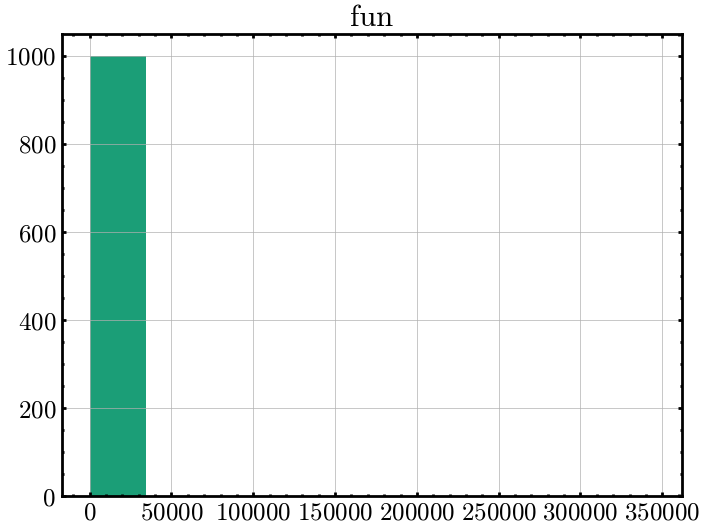

In [61]:
dataframe.hist("fun")

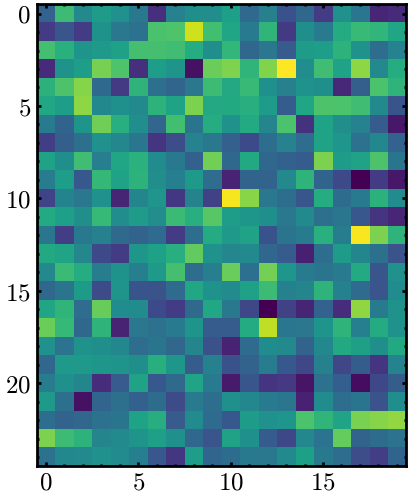

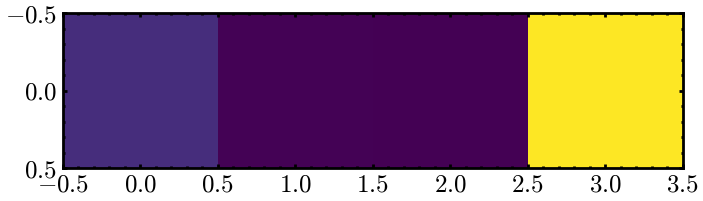

In [21]:
plt.imshow(dataframe["values"][0].reshape(25, 20))
plt.show()
plt.imshow([parm_vals[0]])
plt.show()

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def animation():
    n = len(dataframe)

    # Create a set of arrays
    data = [dataframe["values"][i].reshape(25, 20) for i in range(n)]

    # Set up the figure, axis, and initial imshow object
    fig, axs = plt.subplots(2,1)
    im1 = axs[0].imshow(data[0], animated=True)
    im2 = axs[1].imshow([parm_vals[0]], animated=True)

    # Define the update function
    def update(frame):
        im1.set_array(data[frame])
        im2.set_array([parm_vals[frame]])
        _data = (dataframe.iloc[frame])

        text_ = f"fun: {_data['fun']**0.5:.1f}, nfev: {_data['nfev']}"
        axs[0].set_title(text_)
        return [im]

    # Create the animation object
    ani = FuncAnimation(fig, update, frames=len(data), blit=True)

    # Convert the animation to HTML and save it
    html_content = HTML(ani.to_jshtml()).data
    with open("animation.html", "w") as f:
        f.write(html_content)

    print("Animation saved as animation.html")


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>
2023-09-04 10:10:01 | INFO | animation:save:1043 - Animation.save using <class 'matplotlib.animation.HTMLWriter'>
INFO:matplotlib.animation:Disabling savefig.bbox = 'tight', as it may cause frame size to vary, which is inappropriate for animation.
2023-09-04 10:10:01 | INFO | animation:save:1058 - Disabling savefig.bbox = 'tight', as it may cause frame size to vary, which is inappropriate for animation.
DEBUG:matplotlib.animation:frame size in pixels is 800 x 600
2023-09-04 10:10:01 | DEBUG | animation:_adjust_frame_size:309 - frame size in pixels is 800 x 600
2023-09-04 10:11:21 | WARNING | animation:grab_frame:768 - Animation size has reached 20990940 bytes, exceeding the limit of 20971520.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.
DEBUG:matplotlib.animation:MovieWriter: cle

Animation saved as animation.html


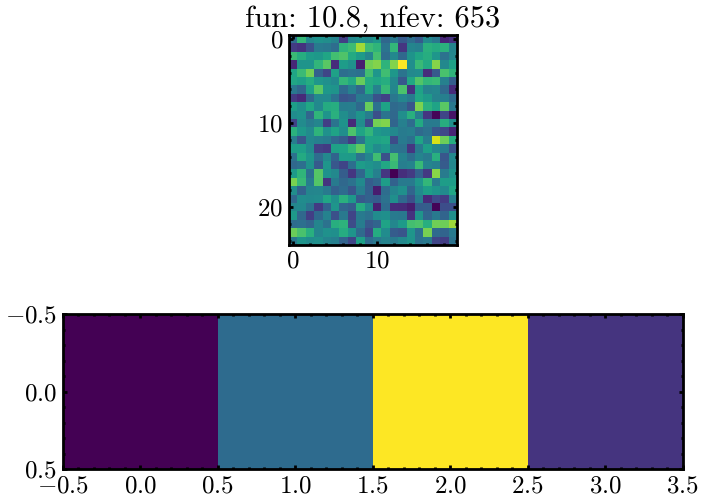

In [58]:
animation()